<a href="https://colab.research.google.com/github/lorrespz/Image-Classification-Collection/blob/main/Generative_Adversarial_Network_GAN_for_image_generations_%5BPyTorch%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network - GAN for image generation

This code is from Lazy Programmer's PyTorch course. However, this notebook doesn't use the MNIST dataset for image training and generation purpose but uses the FashionMNIST dataset (also from torchvision). The full list of built-in datasets in the torchvision library is:
https://pytorch.org/vision/0.16/datasets.html

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [2]:
# A LIST OF IMAGE TRANSFORMATIONS
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean = (0.5,),
                                                     std = (0.5,))])

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root = '.',
                                                  train = True,
                                                transform = transform,
                                                download = True)

100%|██████████| 26421880/26421880 [00:02<00:00, 9435023.33it/s] 


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 169306.50it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3159012.05it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18973881.36it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
len(train_dataset)

60000

In [5]:
train_dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [6]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

# Build the discriminator & generator

- The discriminator is just a binary classifier with the output of 0 and 1 for 'fake' and 'true' images

- The generator samples from a latent space and generates images from there



In [7]:
D = nn.Sequential(nn.Linear(784, 512),
                  nn.LeakyReLU(0.2),
                  nn.Linear(512, 256),
                  nn.LeakyReLU(0.2),
                  nn.Linear(256,1))

In [9]:
latent_dim = 100
G = nn.Sequential(nn.Linear(latent_dim, 256),
                  nn.LeakyReLU(0.2),
                  nn.BatchNorm1d(256, momentum = 0.7),
                  nn.Linear(256, 512),
                  nn.LeakyReLU(0.2),
                  nn.BatchNorm1d(512, momentum = 0.7),
                  nn.Linear(512, 1024),
                  nn.LeakyReLU(0.2),
                  nn.BatchNorm1d(1024, momentum = 0.7),
                  nn.Linear(1024, 784),
                  nn.Tanh())
#Tanh activation forces the output to be in the range (-1,1)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [11]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [23]:
# Scale image back to (0,1) from (-1,1) which comes from the
#output of the Tanh activation
def scale_image(img):
  out = (img +1)/2
  return out

In [13]:
#Create a folder to store the generated images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

# Training loop

In [19]:
# Labels to use in the loop
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)
ones_[:5]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [21]:
for inputs, targets in data_loader:
  print(inputs.size(0))
  print(targets)
  break

128
tensor([4, 1, 2, 9, 1, 4, 4, 1, 3, 7, 0, 2, 5, 1, 3, 1, 5, 0, 0, 2, 0, 3, 3, 1,
        8, 2, 6, 5, 5, 8, 2, 3, 6, 4, 3, 7, 1, 5, 5, 1, 3, 3, 7, 2, 6, 6, 6, 2,
        4, 5, 9, 3, 3, 6, 9, 8, 6, 1, 1, 1, 2, 9, 4, 8, 9, 3, 0, 1, 9, 9, 4, 2,
        6, 2, 9, 4, 8, 2, 1, 7, 2, 3, 8, 4, 9, 9, 4, 3, 6, 1, 2, 8, 7, 1, 5, 8,
        1, 0, 8, 0, 0, 9, 7, 8, 4, 6, 5, 0, 2, 0, 1, 6, 4, 3, 2, 5, 5, 0, 2, 0,
        6, 2, 1, 0, 1, 3, 8, 9])


In [24]:
d_losses = []
g_losses = []
for epoch in range(200):
  for inputs, _ in data_loader:
    #inputs.size(0) is the batch_size = 128
    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    #set ones and zeros to correct size
    ones = ones_[:n]
    zeros = zeros_[:n]
    ################################
    #TRAIN DISCRIMINATOR
    ################################
    #real images from the training dataset
    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    #fake images
    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    #gradient descent on the discriminator
    d_loss = 0.5*(d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    ################################
    #TRAIN GENERATOR
    ################################
    for _ in range(2):
      #fake images
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      # reverse the labels
      # since we want the discriminator to think
      #that these are real
      g_loss = criterion(fake_outputs, ones)

      #gradient descent on the generator
      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    # Save losses
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  print(f'Epoch: {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')

  #SAVE GENERATED IMAGES
  fake_images = fake_images.reshape(-1,1,28,28)
  save_image(scale_image(fake_images), f'gan_images/{epoch+1}.png')

Epoch: 0, d_loss: 0.7001636028289795, g_loss: 0.699539065361023
Epoch: 1, d_loss: 0.6955313086509705, g_loss: 0.7038819193840027
Epoch: 2, d_loss: 0.6953374147415161, g_loss: 0.6999751925468445
Epoch: 3, d_loss: 0.6985202431678772, g_loss: 0.6681971549987793
Epoch: 4, d_loss: 0.6971431970596313, g_loss: 0.6831830739974976
Epoch: 5, d_loss: 0.6940842866897583, g_loss: 0.7053507566452026
Epoch: 6, d_loss: 0.6943214535713196, g_loss: 0.6978821158409119
Epoch: 7, d_loss: 0.6934945583343506, g_loss: 0.6958870887756348
Epoch: 8, d_loss: 0.6938167810440063, g_loss: 0.6831404566764832
Epoch: 9, d_loss: 0.6935387849807739, g_loss: 0.6844634413719177
Epoch: 10, d_loss: 0.6939920783042908, g_loss: 0.696743369102478
Epoch: 11, d_loss: 0.6957330703735352, g_loss: 0.696988582611084
Epoch: 12, d_loss: 0.6947313547134399, g_loss: 0.7033392190933228
Epoch: 13, d_loss: 0.6957992315292358, g_loss: 0.6874296069145203
Epoch: 14, d_loss: 0.6924546360969543, g_loss: 0.6902189254760742
Epoch: 15, d_loss: 0.69

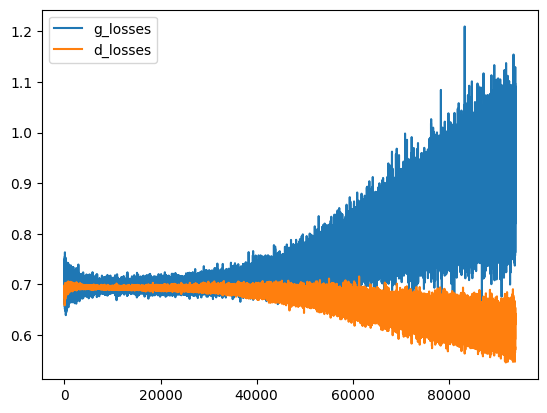

In [25]:
plt.plot(g_losses, label = 'g_losses')
plt.plot(d_losses, label = 'd_losses')
plt.legend()

# Plot the generated images

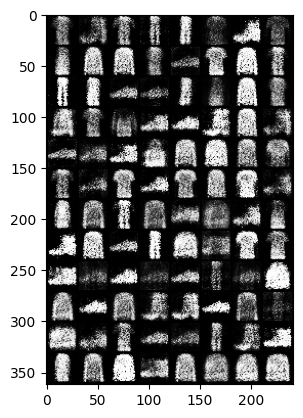

In [26]:
from skimage.io import imread
#Epoch 1
a = imread('gan_images/1.png')
plt.imshow(a)

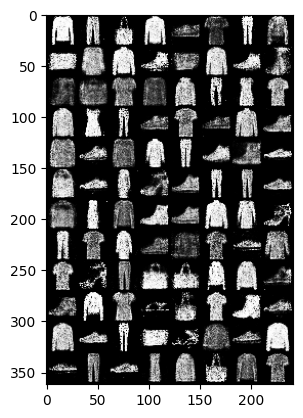

In [27]:
# Epoch 50
a = imread('gan_images/50.png')
plt.imshow(a)

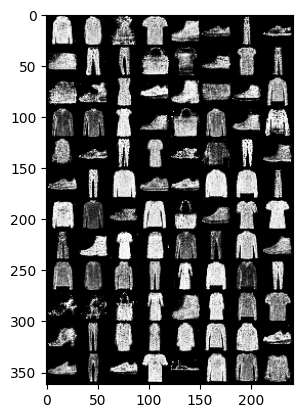

In [28]:
# Epoch 150
a = imread('gan_images/150.png')
plt.imshow(a)

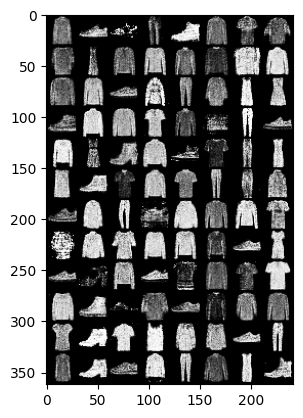

In [29]:
# Epoch 200
a = imread('gan_images/200.png')
plt.imshow(a)